In [1]:
%load_ext autoreload
%autoreload 2

import sys;
sys.path.append(r'.') 
from heisenberg_model import HeisenbergModel; 

!pip install qiskit-ignis
!pip install stable_baselines3 tensorboard
!pip install gym qiskit_experiments

from rl_environment import *

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_92/3452382206.py:6: NatureDeprecationWarning: The qiskit_nature.operators package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.operators package.
  from heisenberg_model import HeisenbergModel;


  Using cached qiskit_ignis-0.7.1-py3-none-any.whl (198 kB)
  Using cached stable_baselines3-1.6.2-py3-none-any.whl (170 kB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
  Using cached gym-0.21.0-py3-none-any.whl
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached Werkzeug-2.2.2-py3-none-any.whl (232 kB)
  Using cached grpcio-1.51.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Markdown-3.4.1-py3-none-any.whl (93 kB)
  Using cached google_auth-2.15.0-py2.py3-none-any.whl (177 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached cachetools-5.2.0-py3-no

In [2]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [3]:
#import retworkx as rx
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from heisenberg_model import HeisenbergModel

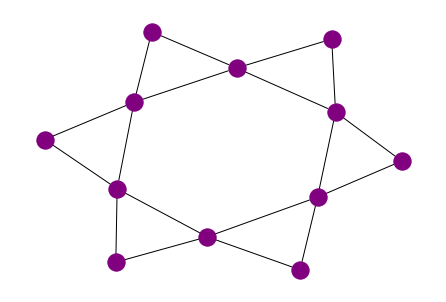

In [4]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

Now that we have the lattice geometry, we can place each term in the Hamiltonian on its corresponding edge. This is done by using the custom `HeisenbergModel` found in the heisenberg_model.py file. This model is based on Qiskit Nature's [`IsingModel` class](https://qiskit.org/documentation/nature/stubs/qiskit_nature.problems.second_quantization.lattice.IsingModel.html) . It places $XX + YY + ZZ$ on each edge of the lattice (per the Hamiltonian's definition).

We will also need to specify how the spin-1/2 particles map to qubits. Using Qiskit nature's `LogarithmicMapper`, we can map each spin-1/2 site to a single qubit. For more information on Qiskit nature's spin mappings see [here]( https://qiskit.org/documentation/nature/stubs/qiskit_nature.mappers.second_quantization.SpinMapper.html#qiskit_nature.mappers.second_quantization.SpinMapper).

In [5]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [6]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

### Compute ground state energy
With the Hamiltonian in hand, we can now calculate the expected ground state and its energy. Qiskit offers different methods to do this. The method [here](https://qiskit.org/documentation/apidoc/algorithms.html#minimum-eigensolvers) computes the ground state energy. This [method](https://qiskit.org/documentation/apidoc/algorithms.html#eigensolvers) computes the ground state ($k=0$) and potentially higher energy states if the users wishes ($k>0$).

Below is an example calculation of finding the lowest 3 energies ($k=3$) of the system using the second method. Remember that for this year's Prize, you will only need to use VQE to find the ground state energy and not any excited state energies.

In [7]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284]


You'll note that -18 is found twice. This means there are actually two ground states for this system. The -16.96 energy is the first excited state, which is not part of this year's challenge. **For this year's Prize, we will only be judging based off the measured ground state energy. This means it does not matter which of the two ground states, or combination of them, your VQE implementation finds.**

In [8]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

In [9]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

# Real backend; needed for transpilation later on
#guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
noisy_sim = FakeGuadalupe()
guadalupe = noisy_sim

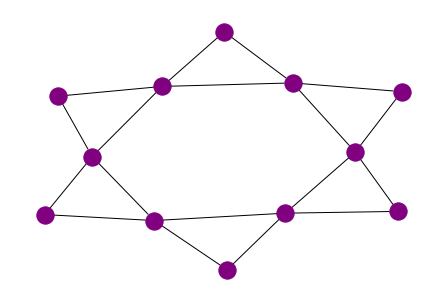

[-18.         -18.         -16.96132284]


In [10]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

from qiskit_nature.mappers.second_quantization import LogarithmicMapper
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

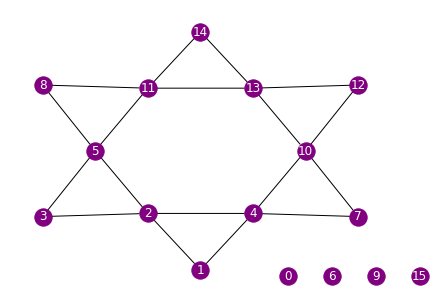

In [11]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [12]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

In [13]:
print(int(np.log2(len( ham_16.to_matrix() ))) )
guadalupe.__class__.__bases__
guadalupe.__class__.__mro__

16


(qiskit.providers.fake_provider.backends.guadalupe.fake_guadalupe.FakeGuadalupe,
 qiskit.providers.fake_provider.fake_pulse_backend.FakePulseBackend,
 qiskit.providers.fake_provider.fake_qasm_backend.FakeQasmBackend,
 qiskit.providers.fake_provider.fake_backend.FakeBackend,
 qiskit.providers.backend.BackendV1,
 qiskit.providers.backend.Backend,
 abc.ABC,
 object)

## 2-3 Define an ansatz
Crafting the ansatz is critical to VQE. You may use a prebuilt ansatz from the [qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits). You may also make your own custom ansatz. Keep in mind that a custom ansatz should have no measurement gates at the end and the circuit parameters are defined by using `Parameter()` [objects](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html). We've demonstrated both options below. The ansatz can be defined over 12 qubits without needed to inflate it to 16 qubits at this point. The transpiler will take care of that later on.

Here's an example using `EfficientSU2()` to generate an ansatz

In [14]:
ansatz_opt = QuantumCircuit(16)

from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=75)

from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

from qiskit.primitives import Estimator
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_16])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)


init simulator statevector_simulator
DONE


/opt/conda/lib/python3.8/site-packages/qiskit/algorithms/optimizers/spsa.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  a = target_magnitude / avg_magnitudes


1.902


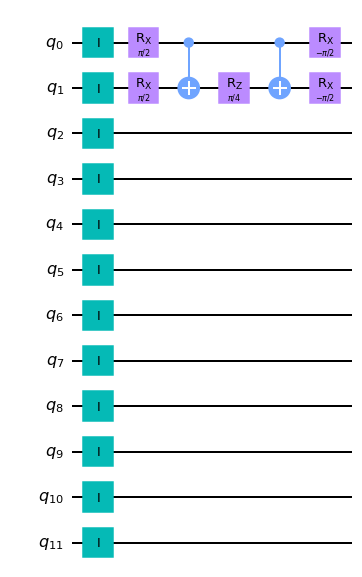

observation: [2.05000000e-16 1.48000000e-16 7.07106781e-01 2.11000000e-16
 8.50000000e-17 7.07106781e-01 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]  fidelity: 1.9023689270621829  > fid treshold: 0.0001  reward: -0.01  gates: 1  action: 1
generated, best_fidelity 
       ┌───┐┌─────────┐                     ┌──────────┐
 q_0: ┤ I ├┤ Rx(π/2) ├──■───────────────■──┤ Rx(-π/2) ├
      ├───┤├─────────┤┌─┴─┐┌─────────┐┌─┴─┐├──────────┤
 q_1: ┤ I ├┤ Rx(π/2) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rx(-π/2) ├
      ├───┤└─────────┘└───┘└─────────┘└───┘└──────────┘
 q_2: ┤ I ├─────────────────────────────

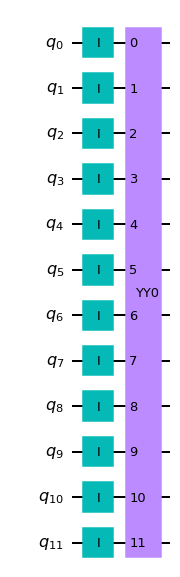

Job Status: job is actively running

In [ ]:
from dataclasses import dataclass

@dataclass
class ProblemConfig:
    model_name = "osp22_lattice"
    target_matrix = ham # ham_16
    target_energy = gs_energy
    #target_matrix = ham_16.to_matrix()
    #target_matrix = (One^One^Zero).to_matrix()
    profile = "TROTTER"
    train_method = "LOAD"
    train_cycle_max = 20
    problem_size = 12

'''    
    model_name = "osp22_lattice"
    train_method = "LOAD"
    train_cycle_max = 2
    profile = "TROTTER"
    problem = {
        "target_matrix": ham_16
        "profile": "TROTTER"
    }

model_name = "dqn_lab4quantum_test"
target_matrix = ham_16.to_matrix()
# profiles TROTTER, GATES, ALL
profile = "TROTTER"
# method TRAIN, LOAD, TEST
train_method = "LOAD"
# Maximum train cycle
train_cycle_max = 2
problem_size = 12
'''
backend = Aer.get_backend('statevector_simulator')
#backend = guadalupe
ansatz_custom = runRLOptimizedCircuit(ProblemConfig.model_name, ProblemConfig.train_method, ProblemConfig.target_matrix, ProblemConfig.target_energy, ProblemConfig.profile, ProblemConfig.train_cycle_max, ProblemConfig.problem_size, backend, estimator, custom_vqe )

ansatz_custom.draw()


### Match qubit layout
The ansatz is currently defined over 12 qubits, but it will be executed on guadalupe which has 16 qubits. To make the ansatz compatible with guadalupe and the inflated Hamiltonian, we can specify the qubit layout on the real device using the transpiler (shown below). We exclude the four qubits with fewest neighbors.

In [ ]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(ansatz_custom, backend=guadalupe, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

## 2-4 Choose a classical optimizer
Select a [classical optimizer](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html#local-optimizers). The classical optimizer will encounter errored and stochastic results from the quantum computer due to gate errors, measurement errors, and other noise sources as well as finite sampling affects [8]. Choose a classical optimizer that pairs well with your approach to VQE. Along with choosing a classical optimizer, picking an initial set of parameters plays a significant role in VQE. In this example, a random set of values is picked (shown in the `CustomVQE` class section 2-5).

\[8\] "Using models to improve optimizers for variational quantum algorithms" K. Sung, et al. [arXiv:2005.11011v2](https://arxiv.org/abs/2005.11011v2) [quant-ph] (2020)

In [ ]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=75)

## 2-5 Define custom VQE program
The VQE calculation can be efficiently orchestrated between the quantum and classical computer using qiskit's [primitives](https://qiskit.org/documentation/apidoc/primitives.html). Below is a simple example of using the [Estimator primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-estimator) with your computer as a local simulator of a quantum computer. It's convenient to bring the components of VQE together into a custom class which we've called `CustomVQE`.

If you want more control over the measurement results and how the expectation values are computed, use the [Sampler primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-sampler) which will output the probabilities (or quasi-probabilities) of every measured state instead of expectation values.

In [ ]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


### Callback
It's important to know what's going on between the classical and quantum computer during the optimization. What parameter values is the classical optimizer picking? How does the convergence to the ground state energy behave?

Defining a callback function gives us a chance to peek in. A simple callback method is defined below. See [this tutorial](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html) for more information and be sure to read the classical [optimizers' docs](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) for what specific values can be extracted during optimization. For example [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html#qiskit.algorithms.optimizers.SPSA) returns: (nfev, parameters, value, stepsize, accepted).

In [ ]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

## 2-6 Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [ ]:
from qiskit.primitives import Estimator

In [ ]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_16])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

In the print out above, the ground state energy is under "eigenvalue", and the optimal choice of parameters that goes with that energy is under "optimal_parameters". Let's plot the energy convergence data the callback function acquired.

In [ ]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

The true ground state energy is -18.0. As a metric for how well the VQE found the ground state energy, we will compute the relative difference between -18.0 and what we just achieved with VQE. This will be the metric of performance in the judging criteria, though it's important to note that it's not the only useful metric when working with VQE. Remember that the lower the relative error the higher you will score.

Expected ground state energy: -18.0000000000
Computed ground state energy: -6.0904576051
Relative error: 0.66164124

In [ ]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

## 3-1 Qiskit runtime (cloud simulator)

Next we demonstrate how to run VQE using [qiskit_ibm_runtime](https://github.com/Qiskit/qiskit-ibm-runtime) **which has different syntax from qiskit terra's runtime**. The qiskit_ibm_runtime module includes the same programming model as qiskit terra, but qiskit_ibm_runtime has access to a cloud simulator and more importantly the ibmq_guadalupe device. To learn more about qiskit_ibm_runtime check out these tutorials from the docs: [a tutorial on the estimator](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-estimator.ipynb) and [a tutorial on the sampler](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-sampler.ipynb).

We will use all the same VQE components we've built up so far, but the syntax for executing on the hardware is wrapped in [a session](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/sessions/) as shown in the following cells.

We first demonstrate running VQE with the cloud simulator backend to check everything is working correctly. This may take a few minutes. After running on the cloud simulator, we make a simple switch of backends to the real ibmq_guadalupe device to get the final result. Depending on how your VQE is setup, this may take a couple hours.

In [ ]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService(channel='ibm_quantum')

In [ ]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'simulator_statevector'

In [ ]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [ ]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')

In [ ]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

# Considerations
Feeling stuck? Below are a list of questions and considerations to help spark new ideas for your VQE implementation.

**Ansatz.** Carefully consult research literature for the best approach of ansatz selection. How might errors affect your ansatz? How many parameters are needed to reach the ground state? What properties of the Hamiltonian could help simplify the ansatz?

**Classical optimizer.** What optimizer will pair well with for your choice of ansatz and measurement parameters? What noise do you expect from the quantum computer, and what noise sensitivity can the classical optimizer withstand? How many iterations will be needed?

**Initial state/point.** Is there an initial quantum state that really helps things get going? What about a starting point for the circuit parameters? Does the VQE give the same results for different initial parameter values?

**Number of measurements.** How does the number of shots affect the VQE's convergence to the ground state energy? The expectation value of the Hamiltonian is a sum of the expectation values of each of the 54 terms. What is the least number of circuit executions necessary to compute the expectation value of the Hamiltonian? What is the optimal number of circuit executions for stable convergence?

**Many qubits.** Working with larger numbers of qubits is its own challenge. For example, what's a concise way of writing down or even visualizing the 4096 digit ground state? What methods and techniques will not scale well? What techniques would scale well if this VQE were to be done on a larger system? How can you reduce your execution time of the real device?

**Error mitigation.** What errors are most prevalent, and how can you reduce them efficiently? What error mitigation techniques will scale well?

In [ ]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table